In [208]:
import pandas as pd
import numpy as np

## DRE

In [209]:
df_DRE = pd.read_csv('historic_data/historico_DRE.csv',sep=';',encoding='latin-1')

In [210]:
df_DRE.columns = [k.strip() for k in df_DRE.columns]
df_DRE.columns

Index(['safra', 'custo de bens e ou serviços vendidos',
       'deduções da receita bruta', 'despesas', 'despesas com vendas',
       'despesas da intermediação financeira', 'despesas de pessoal',
       'despesas financeiras', 'despesas gerais e administrativas',
       'despesas tributárias', 'financeiras', 'ir diferido',
       'lucro prejuízo do período', 'outras despesas administrativas',
       'outras despesas operacionais', 'outras despesas receitas operacionais',
       'outras receitas operacionais', 'part. de acionistas não controladores',
       'participações contribuições estatutárias',
       'perdas pela não recuperabilidade de ativos',
       'provisão para ir e contribuição social',
       'receita bruta de vendas e ou serviços',
       'receita líquida de vendas e ou serviços', 'receitas',
       'receitas da intermediação financeira',
       'receitas de prestação de serviços', 'receitas financeiras',
       'resultado antes tributação participações', 'resultado bru

In [211]:
# (3) = (1)-(2)
# (5) = (3)-(4)
# (8) = (5)-[(6)-(7.1)+(7.2)]
# (10) = (8)-(9)
# (12) = (10)-[(11.2)-(11.1)]
# (15) = (12)-(13.1)+(13.2)-(14)

# Para financeiras, receitas e despesas da intermediação financeira são receita bruta e deduções sobre ela
# "outras despesas receitas operacionais" - somar direto com valor original (pode mesclar positivo ou negativo)

dict_cols = {'1 - Receita bruta':['receita bruta de vendas e ou serviços','receitas da intermediação financeira'],
             '2 - Deduções sobre receita bruta':['deduções da receita bruta'],
             '3 - Receita líquida':['receita líquida de vendas e ou serviços'],
             '4 - Custo de mercadorias e serviços vendidos (CMV)':['custo de bens e ou serviços vendidos',
                                                                   'despesas da intermediação financeira'],
             '5 - Resultado bruto':['resultado bruto','resultado bruto intermediação financeira'],
             '6 - Despesas com vendas':['despesas com vendas'],
             '7.1 - Receitas operacionais':['outras receitas operacionais','receitas',
                                            'outras despesas receitas operacionais',
                                            'receitas de prestação de serviços'],
             '7.2 - Despesas gerais, administrativas e de pessoal':['despesas gerais e administrativas',
                                                                    'perdas pela não recuperabilidade de ativos',
                                                                    'despesas', 'despesas de pessoal',
                                                                    'despesas tributárias','outras despesas operacionais',
                                                                    'outras despesas administrativas'],
             '8 - EBITDA':[],
             '9 - Depreciações e amortizações':[],
             '10 - EBIT':[],
             '11.1 - Receitas financeiras':['receitas financeiras'],
             '11.2 - Despesas financeiras':['despesas financeiras'],
             '12 - EBT':['resultado antes tributação participações'],
             '13.1 - IR e taxas':['provisão para ir e contribuição social'],
             '13.2 - Restituição de IR e taxas':['ir diferido'],
             '14 - Participação de acionistas':['part. de acionistas não controladores',
                                                'participações contribuições estatutárias',
                                                'reversão dos juros sobre capital próprio'],
             '15 - Resultado do período':['lucro prejuízo do período']
            }
vars_consolidacao_originais_base = ['resultado bruto','resultado da equivalência patrimonial','financeiras',
                                    'resultado não operacional','resultado antes tributação participações',
                                    'lucro prejuízo do período','resultado bruto intermediação financeira',
                                    'resultado operacional']

In [212]:
cols_consideradas = []
for col in list(dict_cols.values()):
    cols_consideradas = cols_consideradas + col
cols_n_consideradas = ((set(df_DRE.columns) - set(['safra','ticker'])) - set(cols_consideradas)) - set(vars_consolidacao_originais_base)

In [213]:
df_DRE[df_DRE['ticker']=='SQIA3']['provisão para ir e contribuição social']

18003    -558.000
18004    -216.000
18005   -2216.000
18006   -1246.000
18007    -281.000
18008    -206.000
18009    -650.000
18010    -264.000
18011    -101.000
18012     -51.000
18013   -1200.000
18014    -275.000
18015    -923.000
18016    -862.000
18017     929.312
18018    -186.478
18019     362.494
18020    -591.810
18021    -525.328
18022   -1544.515
18023     649.372
18024    -387.851
18025      23.723
18026    -292.158
18027    -255.940
18028     -35.378
18029   -1446.546
18030    -313.468
18031    -399.016
18032    -219.645
Name: provisão para ir e contribuição social, dtype: float64

In [214]:
def concatena_cols_df(df,cols):
    df = df.copy()
    df['dummy_col'] = 0
    for col in cols:
        df['dummy_col'] = df['dummy_col'] + df[col].fillna(0)
    return df['dummy_col']

df_DRE_simp = df_DRE[['safra','ticker']].copy()
for lin in dict_cols.keys():
    if '3 - ' in lin:
        df_DRE_simp[lin] = concatena_cols_df(df_DRE,dict_cols[lin])
        df_DRE_simp[lin] = [l1 - l2 if l3==0 else l3 for (l1,l2,l3) in zip(df_DRE_simp['1 - Receita bruta'],\
                                                                           df_DRE_simp['2 - Deduções sobre receita bruta'],\
                                                                           df_DRE_simp['3 - Receita líquida'])]
    elif '5 - ' in lin and 'bruto' in lin:
        df_DRE_simp[lin] = df_DRE_simp['3 - Receita líquida'] + \
        df_DRE_simp['4 - Custo de mercadorias e serviços vendidos (CMV)']
    elif '8 - ' in lin:
        df_DRE_simp[lin] = df_DRE_simp['5 - Resultado bruto'] + df_DRE_simp['6 - Despesas com vendas'] \
        + df_DRE_simp['7.1 - Receitas operacionais'] + df_DRE_simp['7.2 - Despesas gerais, administrativas e de pessoal']
    elif '9 - ' in lin:
        df_DRE_simp[lin] = 0
    elif '10 - ' in lin:
        df_DRE_simp[lin] = df_DRE_simp['8 - EBITDA'] + df_DRE_simp['9 - Depreciações e amortizações']
    elif '12 - ' in lin:
        df_DRE_simp[lin] = df_DRE_simp['10 - EBIT'] + df_DRE_simp['11.2 - Despesas financeiras'] \
        + df_DRE_simp['11.1 - Receitas financeiras']
    elif '15 - ' in lin:
        df_DRE_simp[lin] = df_DRE_simp['12 - EBT'] + df_DRE_simp['13.1 - IR e taxas'] + \
        df_DRE_simp['13.2 - Restituição de IR e taxas'] + df_DRE_simp['14 - Participação de acionistas']
    else:
        df_DRE_simp[lin] = concatena_cols_df(df_DRE,dict_cols[lin])

In [215]:
df_DRE_simp[df_DRE_simp['ticker']=='ABEV3']

,safra,ticker,1 - Receita bruta,2 - Deduções sobre receita bruta,3 - Receita líquida,4 - Custo de mercadorias e serviços vendidos (CMV),5 - Resultado bruto,6 - Despesas com vendas,7.1 - Receitas operacionais,"7.2 - Despesas gerais, administrativas e de pessoal",8 - EBITDA,9 - Depreciações e amortizações,10 - EBIT,11.1 - Receitas financeiras,11.2 - Despesas financeiras,12 - EBT,13.1 - IR e taxas,13.2 - Restituição de IR e taxas,14 - Participação de acionistas,15 - Resultado do período
97,30/06/2019,ABEV3,0.0,0.0,1.214513e+07,-4961300.992,7.183832e+06,-3085117.952,273441.984,-823977.000,3548178.584,0,3548178.584,249903.008,-817340.032,2980741.560,-807523.968,443414.016,-95168.000,2521463.608
98,31/03/2019,ABEV3,0.0,0.0,1.264013e+07,-5107701.248,7.532425e+06,-3028003.072,285051.008,-733739.984,4055732.656,0,4055732.656,287692.992,-959761.024,3383664.624,-979185.024,346724.000,-87218.000,2663985.600
99,31/12/2018,ABEV3,0.0,0.0,1.601783e+07,-6050933.760,9.966896e+06,-3309092.864,357825.024,-806363.904,6209264.384,0,6209264.384,19940.992,-1638935.808,4590269.568,33055.104,-1160932.992,-103125.984,3359265.696
100,30/09/2018,ABEV3,0.0,0.0,1.106374e+07,-4370713.088,6.693030e+06,-2892641.024,299072.000,-730708.024,3368753.352,0,3368753.352,245288.992,-856369.024,2757673.320,-475184.992,612889.984,-60947.000,2834431.312
101,30/06/2018,ABEV3,0.0,0.0,1.150954e+07,-4387232.768,7.122312e+06,-3168975.104,463337.984,-766443.008,3650232.064,0,3650232.064,98044.000,-1147111.936,2601164.128,-663297.024,483739.008,-107009.000,2314597.112
102,31/03/2018,ABEV3,0.0,0.0,1.164022e+07,-4460747.776,7.179471e+06,-3095288.064,307433.984,-630448.976,3761167.792,0,3761167.792,375540.992,-919833.984,3216874.800,-728052.992,108190.000,-81667.000,2515344.808
103,31/12/2017,ABEV3,0.0,0.0,1.502722e+07,-4988325.888,1.003889e+07,-3168599.040,476209.024,-1072207.984,6274292.496,0,6274292.496,341733.984,-1589280.768,5026745.712,-358014.464,-1364499.072,-179888.000,3124344.176
104,30/09/2017,ABEV3,0.0,0.0,1.136230e+07,-4482122.240,6.880181e+06,-2971041.024,289769.984,-585140.008,3613769.688,0,3613769.688,186131.008,-861062.976,2938837.720,-3715267.072,917454.016,-136267.008,4757.656
105,30/06/2017,ABEV3,0.0,0.0,1.026795e+07,-4048188.928,6.219764e+06,-2850624.000,258148.000,-588443.000,3038845.224,0,3038845.224,122870.000,-821692.032,2340023.192,-577296.000,356836.992,-111685.000,2007879.184
106,31/03/2017,ABEV3,0.0,0.0,1.124180e+07,-4523141.120,6.718664e+06,-2925230.080,314820.000,-608347.008,3499906.592,0,3499906.592,123663.000,-996257.984,2627311.608,-681758.976,343246.016,-90696.000,2198102.648


## BP

In [216]:
df_BP = pd.read_csv('historic_data/historico_balanco_patrimonial.csv',sep=';',encoding='latin-1')
df_BP.columns = [k.strip() for k in df_BP.columns]
df_BP.columns

Index(['safra', 'ativo - aplicações financeiras',
       'ativo - aplicações financeiras avaliadas a valor justo',
       'ativo - aplicações financeiras avaliadas ao custo amortizado',
       'ativo - aplicações interfinanceiras de liquidez',
       'ativo - aplicações interfinanceiras de liquidez 1',
       'ativo - ativo circulante', 'ativo - ativo permanente',
       'ativo - ativo realizável a longo prazo', 'ativo - ativo total',
       'ativo - ativos biológicos', 'ativo - ativos biológicos 1',
       'ativo - caixa e equivalentes de caixa', 'ativo - contas a receber',
       'ativo - contas a receber 1', 'ativo - despesas antecipadas',
       'ativo - despesas antecipadas 1', 'ativo - diferido',
       'ativo - disponibilidades', 'ativo - estoques', 'ativo - estoques 1',
       'ativo - imobilizado', 'ativo - intangível', 'ativo - investimentos',
       'ativo - operações de arrendamento mercantil',
       'ativo - operações de arrendamento mercantil 1',
       'ativo - operaçõe

In [217]:
# Adotar a seguinte estratégia: Pegar "Ativo Total", fazer a conta certa para "Ativo Circulante" e descontar para obter "Ativo não circulante" (várias planilhas estão com problemas de dados)

dict_cols_BP = {'Ativo Circulante':{'Caixa Equivalentes e Disponibilidades':
                                    ['ativo - caixa e equivalentes de caixa',
                                     'ativo - aplicações financeiras',
                                     'ativo - aplicações interfinanceiras de liquidez',
                                     'ativo - disponibilidades'],
                                    'Estoques':['ativo - estoques'],
                                    'Títulos e Valores Mobiliários':['ativo - títulos e valores mobiliários'],
                                    'Contas a receber arrendamentos e biologicos':['ativo - contas a receber',
                                                                                   'ativo - operações de arrendamento mercantil',
                                                                                   'ativo - ativos biológicos',
                                                                                   'ativo - relações interdependências',
                                                                                   'ativo - relações interfinanceiras'
                                                                                  ],
                                    'Operacoes de credito':['ativo - operações de crédito',
                                                            'ativo - outros créditos'],
                                    'Despesas antecipadas':['ativo - despesas antecipadas'],
                                    'Taxas e tributos a recuperar':['ativo - tributos a recuperar'],
                                    'Outros ativos circulantes':['ativo - outros ativos circulantes',
                                                                 'ativo - outros valores e bens'],
                                   },
#                 'Ativo Nao Circulante':{'ativo nao circulante summary':['ativo total','ativo - ativo total','Ativo Circulante']},
                'Ativo Nao Circulante granulares':{'Aplicacoes financeiras amortizadas':['ativo - aplicações financeiras avaliadas ao custo amortizado',
                                                                              'ativo - contas a receber 1',
                                                                              'ativo - aplicações financeiras avaliadas a valor justo',
                                                                              'ativo - aplicações interfinanceiras de liquidez 1'],
                                        'Estoques a comercializar e arrendamentos':['ativo - estoques 1',
                                                                                    'ativo - operações de arrendamento mercantil 1'],
                                        'Despesas antecipadas':['ativo - despesas antecipadas 1'],
                                        'Tributos diferidos':['ativo - tributos diferidos'],
                                        'Investimentos e operacoes de credito':['ativo - investimentos',
                                                                                'ativo - operações de crédito 1'],
                                        'Títulos e valores mobiliários':['ativo - títulos e valores mobiliários 1'],
                                        'Outros ativos nao circulantes':['ativo - outros ativos não circulantes',
                                                                         'ativo - ativo permanente',
                                                                         'ativo - ativo realizável a longo prazo',
                                                                         'ativo - ativos biológicos 1',
                                                                         'ativo - outros créditos 1',
                                                                         'ativo - outros valores e bens 1',
                                                                         'ativo - relações interdependências 1',
                                                                         'ativo - relações interfinanceiras 1'],
                                        'Imobilizado':['ativo - imobilizado'],
                                        'Intangível':['ativo - intangível']
                },
                'Passivo Circulante':{'Emprestimos e financiamentos':['passivo - empréstimos e financiamentos'],
                                      'Recebíveis de fornecedores':['passivo - fornecedores'],
                                      'Obrig. sociais e trabalhistas':['passivo - obrigações sociais e trabalhistas'],
                                      'Captações no Mercado Aberto e depósitos':['passivo - captações no mercado aberto',
                                                                                 'passivo - depósitos'],
                                      'Recursos de aceites cambiais':['passivo - recursos de aceites e emissão de títulos'],
                                      'Relações interdependencias e interfinanceiras':['passivo - relações interdependências',
                                                                                       'passivo - relações interfinanceiras'],
                                      'Passivos sobre ativos a venda':['passivo - passivos sobre ativos não-correntes a venda e descontinuados'],
                                      'Provisoes':['passivo - provisões'],
                                      'Lucros nao distribuídos':['passivo - dividendos e jcp a pagar'],
                                      'Obrigacoes fiscais': ['passivo - obrigações fiscais'],
                                      'Obrigacoes por emprestimos e repasses':['passivo - obrigações por empréstimos',
                                                                               'passivo - obrigações por repasse do exterior',
                                                                               'passivo - obrigações por repasse do país'],
                                      'Outros passivos circulantes':['passivo - outros',
                                                                     'passivo - outras obrigações']
                },
                'Passivo Nao Circulante':{'Emprestimos e financiamentos':['passivo - empréstimos e financiamentos 1'],
                                          'Captações no Mercado Aberto e depósitos':['passivo - captações no mercado aberto 1',
                                                                                     'passivo - depósitos 1',
                                                                                     'passivo - passivo exigível a longo prazo'],
                                          'Provisoes para contingencias':['passivo - provisões 1'],
                                          'Receitas Diferidas':['passivo - lucros e receitas a apropriar'],
                                          'Recursos de aceites cambiais':['passivo - recursos de aceites e emissão de títulos 1'],
                                          'Relações interdependencias e interfinanceiras':['passivo - relações interdependências 1',
                                                                                           'passivo - relações interfinanceiras 1'],
                                          'Obrigacoes por emprestimos e repasses':['passivo - obrigações por empréstimos 1',
                                                                                   'passivo - obrigações por repasse do exterior 1',
                                                                                   'passivo - obrigações por repasse do país 1'],
                                          'Passivos sobre ativos a venda':['passivo - passivos sobre ativos não-correntes a venda e descontinuados 1'],
                                          'Provisoes para aumento de capital':['passivo - adiantamento para futuro aumento capital'],
                                          'Tributos diferidos':['passivo - tributos diferidos'],
                                          'Outros passivos nao circulantes':['passivo - outros 1',
                                                                             'passivo - outras obrigações 1'],
                                          'Resultados de exercicios futuros':['passivo - resultados de exercícios futuros']
                },
                'Patrimonio Liquido':{'Capital social':['pl - capital social realizado'],
                                      'Particip. acionaistas nao controladores':['passivo - participação dos acionistas não controladores'],
                                      'Reserva para aumento de capital':['pl - adiantamento para futuro aumento capital'],
                                      'Ajustes de PL':['pl - ajustes acumulados de conversão',
                                                       'pl - ajustes de avaliação patrimonial'],
                                      'Reserva de capital':['pl - reservas'],
                                      'Reserva de lucros':['pl - lucros ou prejuízos acumulados'],
                                      'Outros resultados':['pl - outros resultados abrangentes']
                }
    
}

vars_desconsiderar_bp = ['ativo - ativo circulante','ativo - diferido','passivo total','passivo - passivo circulante',
                         'passivo - passivo não circulante','patrimônio líquido']

In [218]:
cols_usadas = []
for it in list(dict_cols_BP.values()):
    for subit in list(it.values()):
        cols_usadas = cols_usadas + list(subit)
cols_n_consideradas = ((set(df_BP.columns) - set(['safra','ticker'])) - set(cols_usadas)) - set(vars_desconsiderar_bp)
cols_n_consideradas

{'ativo - ativo total', 'ativo total'}

In [338]:
df_BP_concat = df_BP[['ticker','safra']].copy()
df_BP_concat['ativo total tabela'] = df_BP[['ativo total','ativo - ativo total']].sum(axis=1)
df_BP_concat['passivo total tabela'] = df_BP['passivo total']
df_BP_concat['patrimônio líquido tabela'] = df_BP['patrimônio líquido']
for k in dict_cols_BP.keys():
    sigla = 'PL'
    if k != 'Patrimonio Liquido':
        sigla = ''
        if 'Ativo' in k:
            sigla+='A'
        else:
            sigla+='P'
            
        if 'Nao' in k:
            sigla+='NC'
        else:
            sigla+='C'
    
    for sk in dict_cols_BP[k].keys():
        df_BP_concat['%s - %s'%(sigla,sk)] = df_BP[dict_cols_BP[k][sk]].sum(axis=1)

### Alguns testes

In [219]:
# Fazer "grandes contas" (sumarizações) e comparar com resultados reais de empresas

In [220]:
df_BP[df_BP.columns[10:15]]

,ativo - ativos biológicos,ativo - ativos biológicos 1,ativo - caixa e equivalentes de caixa,ativo - contas a receber,ativo - contas a receber 1
0,0.0,0.0,61185.000,239312.992,0.000
1,0.0,0.0,64266.000,239566.000,0.000
2,0.0,0.0,73165.000,228960.992,0.000
3,0.0,0.0,46970.000,264752.992,0.000
4,0.0,0.0,63455.000,243296.992,0.000
5,0.0,0.0,68523.000,235863.008,0.000
6,0.0,0.0,91597.000,219178.000,0.000
7,0.0,0.0,50806.000,282444.000,0.000
8,0.0,0.0,51155.000,263584.000,0.000
9,0.0,0.0,53505.000,249166.000,910.000


In [221]:
df_BP[df_BP.columns[10:15]].sum(axis=1)

0         300497.992
1         303832.000
2         302125.992
3         311722.992
4         306751.992
5         304386.008
6         310775.000
7         333250.000
8         314739.000
9         303581.000
10        393485.992
11        287640.008
12        229096.008
13        185551.000
14               NaN
15               NaN
16               NaN
17               NaN
18               NaN
19               NaN
20               NaN
21               NaN
22               NaN
23               NaN
24               NaN
25               NaN
26               NaN
27               NaN
28               NaN
29               NaN
            ...     
21250    1411691.008
21251    1513500.976
21252    1127174.032
21253    1065648.032
21254     998984.968
21255     745085.024
21256     499425.016
21257     558731.000
21258     443140.008
21259     445615.992
21260     341764.000
21261     364963.000
21262     352780.016
21263     365759.992
21264     297788.992
21265     276223.008
21266     370

In [222]:
df_teste = pd.DataFrame({'A':[1,2,3,4],'B':[10,20,30,40]})
df_teste['C'] = np.nan
df_teste

,A,B,C
0,1,10,NaN
1,2,20,NaN
2,3,30,NaN
3,4,40,NaN


In [223]:
df_teste[['B','C']].sum(axis=1)

0    10.0
1    20.0
2    30.0
3    40.0
dtype: float64

In [224]:
df_BP_concat = df_BP[['ticker','safra']].copy()
df_BP_concat['ativo total'] = df_BP[['ativo total','ativo - ativo total']].sum(axis=1)
df_BP_concat['passivo total'] = df_BP['passivo total']
df_BP_concat['patrimônio líquido'] = df_BP['patrimônio líquido']
for k in dict_cols_BP.keys():
    sigla = 'PL'
    if k != 'Patrimonio Liquido':
        sigla = ''
        if 'Ativo' in k:
            sigla+='A'
        else:
            sigla+='P'
            
        if 'Nao' in k:
            sigla+='NC'
        else:
            sigla+='C'
    
    for sk in dict_cols_BP[k].keys():
        df_BP_concat['%s - %s'%(sigla,sk)] = df_BP[dict_cols_BP[k][sk]].sum(axis=1)

In [278]:
cols = [c for c in df_BP_concat.columns if 'PL' in c]
df_result = pd.DataFrame({'ticker':df_BP['ticker'],'safra':df_BP['safra'],'PL_total':df_BP_concat[cols].sum(axis=1)})
df_result['ativo total'] = df_BP_concat['ativo total']
df_result['passivo total'] = df_BP_concat['passivo total']
df_result['patrimônio líquido'] = df_BP_concat['patrimônio líquido']
df_result[df_result['ticker']=='SQIA3']

,PL_total,safra,ticker,ativo total,passivo total,patrimônio líquido
18039,88658.000,30/06/2019,SQIA3,280164.992,280164.992,88651.000
18040,82915.000,31/03/2019,SQIA3,228264.992,228264.992,82910.000
18041,85647.000,31/12/2018,SQIA3,167430.000,167430.000,85350.000
18042,85402.000,30/09/2018,SQIA3,157100.000,157100.000,84999.000
18043,84055.000,30/06/2018,SQIA3,154286.000,154286.000,83680.000
18044,73765.000,31/03/2018,SQIA3,152720.992,152720.992,73765.000
18045,75607.000,31/12/2017,SQIA3,157500.992,157500.992,75607.000
18046,74848.000,30/09/2017,SQIA3,150920.992,150920.992,74848.000
18047,72339.000,30/06/2017,SQIA3,148932.000,148932.000,72339.000
18048,70830.000,31/03/2017,SQIA3,150748.992,150748.992,70830.000


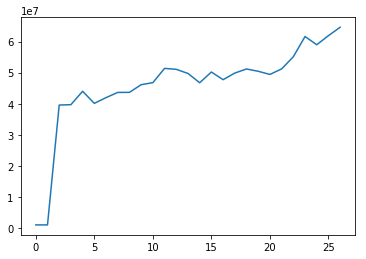

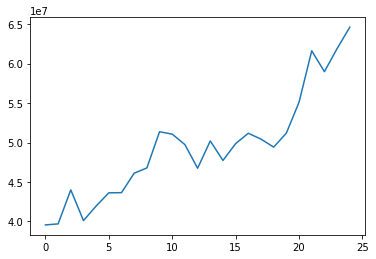

In [337]:
ticker = 'ABEV3'
dados = list(df_result[df_result['ticker']==ticker]['PL_total'])
dados.reverse()
plt.plot(dados)
plt.show()

d = []
dados = list(df_result[df_result['ticker']==ticker]['PL_total'])
for p in range(1,len(dados)):
    d = d + [dados[p-1]-dados[p]]
d = list(np.abs(d))
md = np.median(d)
std = 1.5*np.std(d)
try:
    idx = np.max(list([d.index(k) for k in d if k>=md+std]))
except:
    idx = len(dados)
dados = dados[0:idx+1]
dados.reverse()
plt.plot(dados)
plt.show()